In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statisticsa
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from datetime import date
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

d:\python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
# 读取数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submit.csv')

In [27]:
#查看是否有重复值
d=0
for i in train.duplicated():
    if i !=False:
        d+=1
print("d:",d)

d: 0


In [3]:
# 获得球员年龄
today = pd.to_datetime(date(2018, 4, 15))

train['birth_date'] = pd.to_datetime(train['birth_date'])
train['age'] = (today - train['birth_date']).apply(lambda x: x.days) / 365.

test['birth_date'] = pd.to_datetime(test['birth_date'])
test['age'] = (today - test['birth_date']).apply(lambda x: x.days) / 365.


# 获得球员最擅长位置上的评分
positions = ['rw', 'rb', 'st', 'lw', 'cf', 'cam', 'cm', 'cdm', 'cb', 'lb', 'gk']

train['best_pos'] = train[positions].max(axis=1)
test['best_pos'] = test[positions].max(axis=1)


# 计算球员的身体质量指数(BMI)
train['BMI'] = 10000. * train['weight_kg'] / (train['height_cm'] ** 2)
test['BMI'] = 10000. * test['weight_kg'] / (test['height_cm'] ** 2)


# 判断一个球员是否是守门员
train['is_gk'] = train['gk'] > 0
test['is_gk'] = test['gk'] > 0

In [4]:
#合并数据
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.y.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['y'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (17441, 68)


In [5]:
#独热编码
colunms_to_enconding=['work_rate_att','work_rate_def','preferred_foot','is_gk']
all_data=pd.get_dummies(all_data,columns=colunms_to_enconding)

In [6]:
#后面少部分空值数都相差不大，而且都是一些运球型属性，所以这些空值应该是来自守门员
for col in ('id','lb', 'cb', 'cdm', 'cm','cam','cf','lw','st','rb','rw','birth_date','gk',
            'gk_diving','gk_handling','gk_kicking','gk_positioning','gk_reflexes'
            ,'nationality'):
     all_data=all_data.drop(col,axis=1)

In [7]:
all_data

club  league  height_cm  weight_kg  potential  pac  sho  pas  dri  def  \
0       293      25        177         72         73   65   60   63   67   47   
1       258      24        178         70         62   56   39   60   63   63   
2       112       3        177         69         68   68   57   39   55   19   
3       604       9        181         81         81   76   74   74   77   77   
4        80      37        179         75         72   40   62   74   71   65   
...     ...     ...        ...        ...        ...  ...  ...  ...  ...  ...   
17436   453      27        188         85         70   62   52   53   48   71   
17437   146       4        174         68         73   71   50   59   66   25   
17438   591       7        184         76         64   68   66   63   61   19   
17439   563      41        193         80         71   51   38   46   45   70   
17440   187      24        178         73         68   71   60   45   63   19   

       ...  work_rate_att_High  work_rate_att_Low  work_rate_att_Medium  \
0      ...                   0                  0                     1   
1      ...                   0                  0                     1   
2      ...                   0                  0                     1   
3      ...                   1                  0                     0   
4      ...                   0                  0                     1   
...    ...                 ...                ...                   ...   
17436  ...                   0                  0                     1   
17437  ...                   0                  0                     1   
17438  ...                   0                  0                     1   
17439  ...                   0                  0                     1   
17440  ...                   0                  0                     1   

       work_rate_def_High  work_rate_def_Low  work_rate_def_Medium  \
0                       0                  0                     1   
1                       1                  0                     0   
2                       0                  0                     1   
3                       1                  0                     0   
4                       0                  0                     1   
...                   ...                ...                   ...   
17436                   0                  0                     1   
17437                   0                  0                     1   
17438                   0                  0                     1   
17439                   0                  0                     1   
17440                   0                  0                     1   

       preferred_foot_1  preferred_foot_2  is_gk_False  is_gk_True  
0                     1                 0            1           0  
1                     1                 0            1           0  
2                     0                 1            1           0  
3                     1                 0            1           0  
4                     0                 1            1           0  
...                 ...               ...          ...         ...  
17436                 1                 0            1           0  
17437                 0                 1            1           0  
17438                 1                 0            0           1  
17439                 0                 1            1           0  
17440                 1                 0            1           0  

[17441 rows x 55 columns]

In [8]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [9]:
#模型融合
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [10]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [11]:
def rmsle(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [12]:
GBoost = GradientBoostingRegressor(max_depth=45,
                         learning_rate = 0.05,
                         alpha=0.05,                     
                         n_estimators=100,                             
                         verbose = 0)
model_xgb = xgb.XGBRegressor(max_depth=45,
                         learning_rate = 0.1,                         
                         n_estimators=650)
model_lgb = lgb.LGBMRegressor(objective='regression',
                         max_depth=25,
                         learning_rate = 0.1,
                         num_leaves = 25,
                         n_estimators=8000,
                         metric='rmse', 
                         verbose = 0,)
reg_ngk = RandomForestRegressor( max_depth=75,
                         min_samples_split = 2,                       
                         min_samples_leaf = 2,
                         n_estimators=450, 
                         verbose = 0)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [13]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [15]:
stacked_averaged_models = StackingAveragedModels(base_models = (reg_ngk, GBoost, model_lgb, model_xgb),
                                                 meta_model = lasso)



In [ ]:
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [16]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmsle(y_train, stacked_train_pred))


model_xgb.fit(train.values, y_train)
xgb_train_pred = model_xgb.predict(train.values)
xgb_pred = model_xgb.predict(test.values)
print(rmsle(y_train, xgb_train_pred))



model_lgb.fit(train.values, y_train)
lgb_train_pred = model_lgb.predict(train.values)
lgb_pred = model_lgb.predict(test.values)
print(rmsle(y_train, lgb_train_pred))



'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +xgb_train_pred*0.15 + lgb_train_pred*0.15 ))



9.24430403246278
0.00038919584207798493
0.0054091210015499895
RMSLE score on train data:
6.471064751481576


In [17]:
train_new=pd.DataFrame(index=train.index)
for i in range(3):
    if i ==0:
        train_new.loc[:,i]=stacked_train_pred
    elif i==1:
        train_new.loc[:,i]=xgb_train_pred
    else:
        train_new.loc[:,i]=lgb_train_pred
test_new=pd.DataFrame(index=test.index)
for i in range(3):
    if i ==0:
        test_new.loc[:,i]=stacked_pred
    elif i==1:
        test_new.loc[:,i]=xgb_pred
    else:
        test_new.loc[:,i]=lgb_pred

In [20]:
from sklearn.linear_model import Lasso
Lasso = Lasso()
Lasso.fit(train_new, y_train.astype('int'))
y_pred=Lasso.predict(test_new)
rmsle(y_train,Lasso.predict(train_new))

5.876161538138736

In [25]:
test_new.to_csv('stacking_predict.csv')

In [21]:
ensemble = stacked_pred
submit.loc[:, 'y'] = ensemble
submit.to_csv('-2.csv', index=False)

In [22]:
ensemble =  xgb_pred
submit.loc[:, 'y'] = ensemble
submit.to_csv('-1.csv', index=False)

In [23]:
ensemble = lgb_pred
submit.loc[:, 'y'] = ensemble
submit.to_csv('0.csv', index=False)

In [24]:
submit.loc[:, 'y'] = y_pred
submit.to_csv('1.csv', index=False)

In [48]:
ensemble = stacked_pred*0.15 + xgb_pred*0.15 + lgb_pred*0.70
submit.loc[:, 'y'] = ensemble
submit.to_csv('2.csv', index=False)

In [49]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
submit.loc[:, 'y'] = ensemble
submit.to_csv('3.csv', index=False)

In [50]:
ensemble = stacked_pred*0.15 + xgb_pred*0.70 + lgb_pred*0.15
submit.loc[:, 'y'] = ensemble
submit.to_csv('4.csv', index=False)

In [55]:
ensemble = stacked_pred*0.1 + xgb_pred*0.45 + lgb_pred*0.45
submit.loc[:, 'y'] = ensemble
submit.to_csv('5.csv', index=False)

In [51]:
def los_2 (a,b,c,d) :
        y_p=stacked_train_pred*a +xgb_train_pred*b + lgb_train_pred*c+d

        y_=y
        loss=rmsle(y_, y_p)
            
   


        return loss

In [52]:
# Attention: you had better put the aim-function in another file.
def aimfunc(Phen, LegV):  # define the aim function
    """
        定义目标函数，输出个体适应度矩阵和可行矩阵
    """
    global counter
    counter += 1
    print("第{}次迭代开始：".format(counter))
    

    for i_1 in range(Phen.shape[0]):

        a = Phen[i_1, [0]]
        b = Phen[i_1, [1]]
        c = Phen[i_1, [2]]
        d = Phen[i_1, [3]]
        #print(a,b,c)
        Mis_rate=los_2(a,b,c,d)
        #print("Mis_rate：", Mis_rate)
        
        if i_1 == 0:
            diff = np.array([[Mis_rate]])
        else:
            diff = np.append(diff, [[Mis_rate]], axis=0)
        #print("diff.shape:", diff.shape)
        #print()
    #print("[diff, LegV][diff, LegV][diff, LegV][diff, LegV]:", [diff, LegV])
    return [diff, LegV]


第1次迭代开始：
ObjV: (40, 1)
第2次迭代开始：
记录当代种群最优个体目标函数值: 22.29450787090207
第3次迭代开始：
记录当代种群最优个体目标函数值: 16.1952327624902
第4次迭代开始：
记录当代种群最优个体目标函数值: 16.1952327624902
第5次迭代开始：
记录当代种群最优个体目标函数值: 3.336917871016681
第6次迭代开始：
记录当代种群最优个体目标函数值: 3.336917871016681
第7次迭代开始：
记录当代种群最优个体目标函数值: 3.336917871016681
第8次迭代开始：
记录当代种群最优个体目标函数值: 2.7849446164056064
第9次迭代开始：
记录当代种群最优个体目标函数值: 2.7849446164056064
第10次迭代开始：
记录当代种群最优个体目标函数值: 2.560294733653633
第11次迭代开始：
记录当代种群最优个体目标函数值: 2.560294733653633
第12次迭代开始：
记录当代种群最优个体目标函数值: 2.560294733653633
第13次迭代开始：
记录当代种群最优个体目标函数值: 2.560294733653633
第14次迭代开始：
记录当代种群最优个体目标函数值: 2.5377515176412384
第15次迭代开始：
记录当代种群最优个体目标函数值: 1.889772157067008
第16次迭代开始：
记录当代种群最优个体目标函数值: 1.865376872580711
第17次迭代开始：
记录当代种群最优个体目标函数值: 1.6436368079590788
第18次迭代开始：
记录当代种群最优个体目标函数值: 1.6370648523287368
第19次迭代开始：
记录当代种群最优个体目标函数值: 1.6339471637624314
第20次迭代开始：
记录当代种群最优个体目标函数值: 1.6339471637624314
第21次迭代开始：
记录当代种群最优个体目标函数值: 1.6339471637624314
第22次迭代开始：
记录当代种群最优个体目标函数值: 1.6339471637624314
第23次迭代开始：
记录当代种群最优个体目标函数值: 1.6339

第181次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第182次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第183次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第184次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第185次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第186次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第187次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第188次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第189次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第190次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第191次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第192次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第193次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第194次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第195次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第196次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第197次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第198次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第199次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第200次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第201次迭代开始：
记录当代种群最优个体目标函数值: 1.6024280633775443
第202次迭代开始：
记录

第362次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第363次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第364次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第365次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第366次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第367次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第368次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第369次迭代开始：
记录当代种群最优个体目标函数值: 1.412021109928839
第370次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第371次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第372次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第373次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第374次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第375次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第376次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第377次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第378次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第379次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第380次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第381次迭代开始：
记录当代种群最优个体目标函数值: 1.4116040149806068
第382次迭代开始：
记录当代种群最优个体目标函数值: 1.411603724981595
第383次迭代开始：
记录当代种群最优个体目

第540次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第541次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第542次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第543次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第544次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第545次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第546次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第547次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第548次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第549次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第550次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第551次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第552次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第553次迭代开始：
记录当代种群最优个体目标函数值: 0.016718767442635722
第554次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第555次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第556次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第557次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第558次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第559次迭代开始：
记录当代种群最优个体目标函数值: 0.01650334203592014
第560次迭代开始：
记录当代种群最优个体目标函数值

第716次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第717次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第718次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第719次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第720次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第721次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第722次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第723次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第724次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第725次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第726次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第727次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第728次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第729次迭代开始：
记录当代种群最优个体目标函数值: 0.00663413493839443
第730次迭代开始：
记录当代种群最优个体目标函数值: 0.006625205208474565
第731次迭代开始：
记录当代种群最优个体目标函数值: 0.006625205208474565
第732次迭代开始：
记录当代种群最优个体目标函数值: 0.006625205208474565
第733次迭代开始：
记录当代种群最优个体目标函数值: 0.006625205208474565
第734次迭代开始：
记录当代种群最优个体目标函数值: 0.006621894791443713
第735次迭代开始：
记录当代种群最优个体目标函数值: 0.006621894791443713
第736次迭代开始：
记录当代种群最优个体目标函数值: 0.0066

记录当代种群最优个体目标函数值: 0.006616185423968757
第889次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第890次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第891次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第892次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第893次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第894次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第895次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第896次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第897次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第898次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第899次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第900次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第901次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第902次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第903次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第904次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第905次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第906次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第907次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第908次迭代开始：
记录当代种群最优个体目标函数值: 0.0

记录当代种群最优个体目标函数值: 0.006616185423968757
第1056次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1057次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1058次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1059次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1060次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1061次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1062次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1063次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1064次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1065次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1066次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1067次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1068次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1069次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1070次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1071次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1072次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1073次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1074次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1075次迭代开始：


第1225次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1226次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1227次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1228次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1229次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1230次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1231次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1232次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1233次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1234次迭代开始：
记录当代种群最优个体目标函数值: 0.006616185423968757
第1235次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1236次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1237次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1238次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1239次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1240次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1241次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1242次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1243次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1244次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561


记录当代种群最优个体目标函数值: 0.006592359305069561
第1393次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1394次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1395次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1396次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1397次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1398次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1399次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1400次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1401次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1402次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1403次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1404次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1405次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1406次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1407次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1408次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1409次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1410次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1411次迭代开始：
记录当代种群最优个体目标函数值: 0.006592359305069561
第1412次迭代开始：


记录当代种群最优个体目标函数值: 0.0034714704396627476
第1565次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1566次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1567次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1568次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1569次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1570次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1571次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1572次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1573次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1574次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1575次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1576次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1577次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1578次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1579次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1580次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1581次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1582次迭代开始：
记录当代种群最优个体目标函数值: 0.0034714704396627476
第1583次迭代开始：
记录当代种群最优个体目标函数值: 0.003471470439

记录当代种群最优个体目标函数值: 0.0034673307800616856
第1729次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1730次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1731次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1732次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1733次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1734次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1735次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1736次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1737次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1738次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1739次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1740次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1741次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1742次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1743次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1744次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1745次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1746次迭代开始：
记录当代种群最优个体目标函数值: 0.0034673307800616856
第1747次迭代开始：
记录当代种群最优个体目标函数值: 0.003467330780

第1901次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1902次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1903次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1904次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1905次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1906次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1907次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1908次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1909次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1910次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1911次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1912次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1913次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1914次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1915次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1916次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1917次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1918次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1919次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第1920次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012


第2071次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2072次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2073次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2074次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2075次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2076次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2077次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2078次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2079次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2080次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2081次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2082次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2083次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2084次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2085次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2086次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2087次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2088次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2089次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2090次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012


第2244次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2245次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2246次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2247次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2248次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2249次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2250次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2251次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2252次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2253次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2254次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2255次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2256次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2257次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2258次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2259次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2260次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2261次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2262次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2263次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012


记录当代种群最优个体目标函数值: 0.003467236027671012
第2419次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2420次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2421次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2422次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2423次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2424次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2425次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2426次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2427次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2428次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2429次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2430次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2431次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2432次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2433次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2434次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2435次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2436次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2437次迭代开始：
记录当代种群最优个体目标函数值: 0.003467236027671012
第2438次迭代开始：


第2586次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2587次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2588次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2589次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2590次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2591次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2592次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2593次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2594次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2595次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2596次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2597次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2598次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2599次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2600次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2601次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2602次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2603次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2604次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2605次迭代开始：
记录当代种群最优个体目标函数值: 0.

第2754次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2755次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2756次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2757次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2758次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2759次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2760次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2761次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2762次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2763次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2764次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2765次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2766次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2767次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2768次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2769次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2770次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2771次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2772次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2773次迭代开始：
记录当代种群最优个体目标函数值: 0.

第2918次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2919次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2920次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2921次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2922次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2923次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2924次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2925次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2926次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2927次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2928次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2929次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2930次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2931次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2932次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2933次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2934次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2935次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2936次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第2937次迭代开始：
记录当代种群最优个体目标函数值: 0.

第3083次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3084次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3085次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3086次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3087次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3088次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3089次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3090次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3091次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3092次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3093次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3094次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3095次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3096次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3097次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3098次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3099次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3100次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3101次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3102次迭代开始：
记录当代种群最优个体目标函数值: 0.

记录当代种群最优个体目标函数值: 0.0034643882272384074
第3245次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3246次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3247次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3248次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3249次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3250次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3251次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3252次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3253次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3254次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3255次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3256次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3257次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3258次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3259次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3260次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3261次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3262次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3263次迭代开始：
记录当代种群最优个体目标函数值: 0.003464388227

记录当代种群最优个体目标函数值: 0.0034643882272384074
第3408次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3409次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3410次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3411次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3412次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3413次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3414次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3415次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3416次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3417次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3418次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3419次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3420次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3421次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3422次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3423次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3424次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3425次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3426次迭代开始：
记录当代种群最优个体目标函数值: 0.003464388227

第3572次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3573次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3574次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3575次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3576次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3577次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3578次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3579次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3580次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3581次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3582次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3583次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3584次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3585次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3586次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3587次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3588次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3589次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3590次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3591次迭代开始：
记录当代种群最优个体目标函数值: 0.

第3734次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3735次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3736次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3737次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3738次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3739次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3740次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3741次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3742次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3743次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3744次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3745次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3746次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3747次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3748次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3749次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3750次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3751次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3752次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3753次迭代开始：
记录当代种群最优个体目标函数值: 0.

第3897次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3898次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3899次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3900次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3901次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3902次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3903次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3904次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3905次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3906次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3907次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3908次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3909次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3910次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3911次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3912次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3913次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3914次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3915次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第3916次迭代开始：
记录当代种群最优个体目标函数值: 0.

记录当代种群最优个体目标函数值: 0.0034643882272384074
第4065次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4066次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4067次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4068次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4069次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4070次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4071次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4072次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4073次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4074次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4075次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4076次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4077次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4078次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4079次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4080次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4081次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4082次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4083次迭代开始：
记录当代种群最优个体目标函数值: 0.003464388227

记录当代种群最优个体目标函数值: 0.0034643882272384074
第4230次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4231次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4232次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4233次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4234次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4235次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4236次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4237次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4238次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4239次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4240次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4241次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4242次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4243次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4244次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4245次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4246次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4247次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4248次迭代开始：
记录当代种群最优个体目标函数值: 0.003464388227

记录当代种群最优个体目标函数值: 0.0034643882272384074
第4395次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4396次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4397次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4398次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4399次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4400次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4401次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4402次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4403次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4404次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4405次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4406次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4407次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4408次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4409次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4410次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4411次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4412次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4413次迭代开始：
记录当代种群最优个体目标函数值: 0.003464388227

第4558次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4559次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4560次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4561次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4562次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4563次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4564次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4565次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4566次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4567次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4568次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4569次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4570次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4571次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4572次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4573次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4574次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4575次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4576次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4577次迭代开始：
记录当代种群最优个体目标函数值: 0.

第4719次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4720次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4721次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4722次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4723次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4724次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4725次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4726次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4727次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4728次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4729次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4730次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4731次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4732次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4733次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4734次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4735次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4736次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4737次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4738次迭代开始：
记录当代种群最优个体目标函数值: 0.

第4886次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4887次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4888次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4889次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4890次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4891次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4892次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4893次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4894次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4895次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4896次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4897次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4898次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4899次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4900次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4901次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4902次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4903次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4904次迭代开始：
记录当代种群最优个体目标函数值: 0.0034643882272384074
第4905次迭代开始：
记录当代种群最优个体目标函数值: 0.

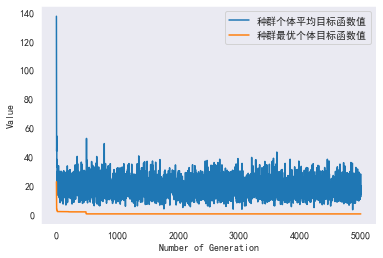

最优解的目标函数值： 0.0034643882272384074
最优解的决策变量值为：
x0= 0.00021978021978021975
x1= 0.5186057868392138
x2= 0.4811744597729215
x3= -9.536747711536009e-05
用时： 111.63204598426819 秒


In [54]:
import geatpy as ga
import time
global counter
counter = 0


"""============================================遗传算法部分================================================="""

"""============================变量设置============================"""
x1 = [0, 0.3]  # 第一个决策变量范围
x2 = [0.3, 1]    # 第二个决策变量范围
x3 = [0.3, 1]  # 第三个决策变量范围
x4=[-50,100]
b1 = [1, 1]  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含
b2 = [1, 1]  # 第二个决策变量边界，1表示包含范围的边界，0表示不包含
b3 = [1, 1]  # 第三个决策变量边界，1表示包含范围的边界，0表示不包含
b4 = [1, 1]  # 第三个决策变量边界，1表示包含范围的边界，0表示不包含
ranges = np.vstack([x1, x2, x3,x4]).T  # 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
borders = np.vstack([b1, b2,b3,b4]).T  # 生成自变量的边界矩阵
varTypes = np.array([0, 0,0,0])  # 决策变量的类型，0表示连续，1表示离散
"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [0, 0,0,0]  # 决策变量的编码方式，设置两个0表示两个决策变量均使用二进制编码
precisions = [4, 4,4,4]  # 决策变量的编码精度，表示二进制编码串解码后能表示的决策变量的精度可达到小数点后6位
scales = [0, 0,0,0]  # 0表示采用算术刻度，1表示采用对数刻度
FieldD = ga.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)  # 调用函数创建译码矩阵
#print("FieldD:",FieldD)
"""=========================遗传算法参数设置========================"""
NIND = 40  # 种群个体数目
MAXGEN = 5000  # 最大遗传代数
maxormins = [1]  # 列表元素为1则表示对应的目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
#print("Lind:",Lind)
pc = 0.7  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
#print("obj_trace:",obj_trace)
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体
#print("var_trace:",var_trace)
"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ga.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
#print("Chrom:",Chrom)
variable = ga.bs2real(Chrom, FieldD)  # 对初始种群进行解码
#print("variable:",variable)
CV = np.zeros((NIND, 1))  # 初始化一个CV矩阵（此时因为未确定个体是否满足约束条件，因此初始化元素为0，暂认为所有个体是可行解个体）
#print("CV:",CV)
ObjV, CV = aimfunc(variable, CV)  # 计算初始种群个体的目标函数值

print("ObjV:",ObjV.shape)
FitnV = ga.ranking(maxormins * ObjV, CV)  # 根据目标函数大小分配适应度值

best_ind = np.argmax(FitnV)  # 计算当代最优个体的序号
"""print("best_ind:",best_ind )
print("best_ind:",FitnV[best_ind ])
print("best_ind:",ObjV[best_ind ])"""
# 开始进化
for gen in range(MAXGEN):
    SelCh = Chrom[ga.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    #print("SelCh:",SelCh)
    SelCh = ga.recombin(recStyle, SelCh, pc)  # 重组
    #print("SelCh:", SelCh)
    SelCh = ga.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    #print("SelCh:", SelCh)
    # 把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ga.bs2real(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV, CV = aimfunc(Phen, CV)  # 求种群个体的目标函数值
    FitnV = ga.ranking(maxormins * ObjV, CV)  # 根据目标函数大小分配适应度值
    # 记录
    best_ind = np.argmax(FitnV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    print('记录当代种群最优个体目标函数值:',obj_trace[gen, 1])
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    #print('记录当代种群最优个体的染色体:',var_trace[gen, :])
# 进化完成
end_time = time.time()  # 结束计时
ga.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像
"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ga.bs2real(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i) + '=', variable[0, i])
print('用时：', end_time - start_time, '秒')

In [56]:
a,b,c,d=variable[0, 0],variable[0, 1],variable[0, 2],variable[0, 3]
ensemble = stacked_pred*a+ xgb_pred*b + lgb_pred*c+d
submit.loc[:, 'y'] = ensemble
submit.to_csv('6.csv', index=False)